In [1141]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [1142]:
plate_cascade = cv2.CascadeClassifier("./model/haarcascade_russian_plate_number.xml")

In [1143]:
def resize_image(image, width = None, height = None):

    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = w / h

    if width is None:
        # Calculate height based on the specified width
        new_height = int(height / aspect_ratio)
        resized_image = cv2.resize(image, (height, new_height))
    else:
        # Calculate width based on the specified height
        new_width = int(width * aspect_ratio)
        resized_image = cv2.resize(image, (new_width, width))

    return resized_image

In [1144]:
def show_image(image, title=""):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [1145]:
def extract_plate(img):
    temp = resize_image(img.copy(), width=460)
    roi = temp.copy()
    gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)

    plate_rect = plate_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=3)

    plate = None

    for x, y, w, h in plate_rect:
        # виконує пропорційне зміщення пікселів
        a, b = (int(0.02 * h), int(0.02 * w))
        aa, bb = (int(0.02 * h), int(0.02 * w))
       
        # roi = temp[y : y + h, x : x + h]
        plate = roi[y + a : y + h - aa, x + b : x + w - bb, :]

        # finally representing the detected contours by drawing rectangles around the edges.
        cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 255, 0), 3)

    return temp, plate

In [1146]:
# Match contours to license plate or character template
def old_find_contours(dimensions, img, debug=False):

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    # 
    ii = np.dstack([img] * 3)

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            # char_copy[2:42, 2:22] = char
            # char_copy[0:2, :] = 0
            # char_copy[:, 0:2] = 0
            # char_copy[42:44, :] = 0
            # char_copy[:, 22:24] = 0

            char_copy[1:43, 1:23] = char
            char_copy[0:1, :] = 0
            char_copy[:, 0:1] = 0
            char_copy[43:44, :] = 0
            char_copy[:, 23:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)

    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
    
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [1147]:
# Відповідність контурів номерному або символьному шаблону
def _find_contours(dimensions, img, debug=False):
    i_width_threshold = 6

    # Знайдіть всі контури на зображенні
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Отримайте потенційні розміри
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Перевірте найбільші 16 контурів на номерний або символьний шаблон
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:16]

    # бінарне зображення номерного знака на вхід: щоб перетворити img.shape(h,w) на img.shape(h,w,3)
    ii = np.dstack([img] * 3)

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # виявлення контуру на бінарному зображенні і повернення координат прямокутника, який його оточує
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # перевірка розмірів контуру для фільтрації символів за розміром контуру
        if (
            intWidth >= i_width_threshold
            and intWidth < upper_width
            and intHeight > lower_height
            and intHeight < upper_height
        ):
            x_cntr_list.append(
                intX
            )  # stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44, 24))
            # видобуття кожного символу, використовуючи координати прямокутника, що його оточує.
            char = img[intY : intY + intHeight, intX : intX + intWidth]

            if intWidth >= i_width_threshold and intWidth < lower_width:
                i_char = cv2.resize(
                    char, (intWidth, 42), interpolation=cv2.INTER_LINEAR_EXACT
                )

                char = np.full((42, 22), 255, dtype=np.uint8)
                begin = int((22 - intWidth) / 2)  # center alignment
                char[:, begin : begin + intWidth] = i_char[:, :]
            else:
                char = cv2.resize(char, (22, 42), interpolation=cv2.INTER_LINEAR_EXACT)

            cv2.rectangle(
                ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2
            )
            if debug :
              plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[1:43, 1:23] = char
            char_copy[0:1, :] = 0
            char_copy[:, 0:1] = 0
            char_copy[43:44, :] = 0
            char_copy[:, 23:24] = 0

            img_res.append(
                char_copy
            )  # List that stores the character's binary image (unsorted)
            if len(img_res) >= 10:
                break

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    if debug:
        plt.axis('off')
        plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(
            img_res[idx]
        )  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [1148]:
def find_contours(dimensions: list, img, debug=False):
    i_width_threshold = 6

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:16]

    ii = np.dstack([img] * 3)  ###

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if (
            intWidth > lower_width
            and intWidth < upper_width
            and intHeight > lower_height
            and intHeight < upper_height
        ):
        # if (
        #     intWidth >= i_width_threshold
        #     and intWidth < upper_width
        #     and intHeight > lower_height
        #     and intHeight < upper_height
        # ):
            x_cntr_list.append(
                intX
            )  # stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY : intY + intHeight, intX : intX + intWidth]

            if intWidth >= i_width_threshold and intWidth < lower_width:
                i_char = cv2.resize(
                    char, (intWidth, 42), interpolation=cv2.INTER_LINEAR_EXACT
                )

                char = np.full((42, 22), 255, dtype=np.uint8)
                begin = int((22 - intWidth) / 2)  # center alignment
                char[:, begin : begin + intWidth] = i_char[:, :]
            else:
                char = cv2.resize(char, (22, 42), interpolation=cv2.INTER_LINEAR_EXACT)

            cv2.rectangle(
                ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2
            )
            if debug:
                plt.imshow(ii, cmap="gray")

            

            #  Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[1:43, 1:23] = char
            char_copy[0:1, :] = 0
            char_copy[:, 0:1] = 0
            char_copy[43:44, :] = 0
            char_copy[:, 23:24] = 0

            img_res.append(
                char_copy
            )  # List that stores the character's binary image (unsorted)
            # MAY BE
            # if len(img_res) >= 10:
            #     break

    # show_image = Image.fromarray(ii)
    # show_image.show()
    
    if debug:
        plt.axis("off")
        plt.show()
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(
            img_res[idx]
        )  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [1149]:
# # Find characters in the resulting images
# def segment_characters(image, debug: bool = False):
#     new_height = 75  # set fixed height

#     # Preprocess cropped license plate image
#     img_lp = cv2.resize(image, (333, new_height), interpolation=cv2.INTER_LINEAR_EXACT)

#     img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
#     _, img_binary_lp = cv2.threshold(
#         img_gray_lp, 112, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
#     )

#     LP_WIDTH = img_binary_lp.shape[0]
#     LP_HEIGHT = img_binary_lp.shape[1]

#     # Make borders white
#     img_binary_lp[0:3, :] = 255
#     img_binary_lp[:, 0:3] = 255
#     img_binary_lp[new_height - 3 : new_height, :] = 255
#     img_binary_lp[:, 330:333] = 255

#     # Estimations of character contours sizes of cropped license plates
#     dimensions = [LP_WIDTH / 24, LP_WIDTH / 8, LP_HEIGHT / 3, 2 * LP_HEIGHT / 3]
#     # dimensions = [LP_WIDTH/6, LP_WIDTH / 2, LP_HEIGHT / 3, 2 * LP_HEIGHT / 3]
#     # dimensions = [LP_WIDTH/12, LP_WIDTH / 4, LP_HEIGHT / 2, 2 * LP_HEIGHT / 3]

#      # Estimations of character contours sizes of cropped license plates
#     dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    
#     plt.imshow(img_binary_lp, cmap='gray')
#     plt.axis('off')
#     plt.show()
    
#     # if debug:
#     #     plt.imshow(img_binary_lp, cmap='gray')
#     #     plt.title("original plate contour (binary)")
#     #     plt.show()

#     # Get contours within cropped license plate
#     char_list = find_contours(dimensions, img_binary_lp, debug = True)

#     for i in range(len(char_list)):
#         plt.subplot(1, 10, i+1)
#         plt.imshow(char_list[i], cmap='gray')
#         plt.axis('off')

#     return char_list

# Find characters in the resulting images
def segment_characters(image, debug: bool = False):
    new_height = 75  # set fixed height

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, new_height), interpolation=cv2.INTER_LINEAR_EXACT)

    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(
        img_gray_lp, 112, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    LP_WIDTH = img_binary_lp.shape[1]
    LP_HEIGHT = img_binary_lp.shape[0]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[new_height - 3 : new_height, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH / 24, LP_WIDTH / 8, LP_HEIGHT / 3, 2 * LP_HEIGHT / 3]
    # dimensions = [LP_WIDTH/6, LP_WIDTH / 2, LP_HEIGHT / 3, 2 * LP_HEIGHT / 3]
    # dimensions = [LP_WIDTH/12, LP_WIDTH / 4, LP_HEIGHT / 2, 2 * LP_HEIGHT / 3]

    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]

    plt.imshow(img_binary_lp, cmap='gray')
    plt.axis('off')
    plt.show()
    # if debug:
    #     plt.imshow(img_binary_lp, cmap='gray')
    #     plt.title("original plate contour (binary)")
    #     plt.show()

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp, debug = debug)

    for i in range(len(char_list)):
        plt.subplot(1, 10, i+1)
        plt.imshow(char_list[i], cmap='gray')
        plt.axis('off')

    return char_list

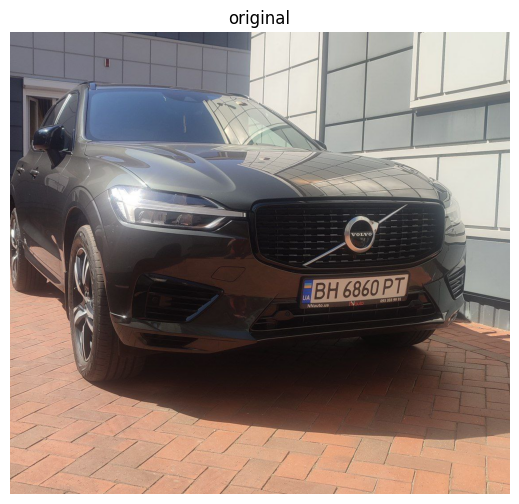

In [1150]:
img_car_original = cv2.imread('image_vehile/real_image/BH 6860 PT.jpg')

show_image(img_car_original, "original")

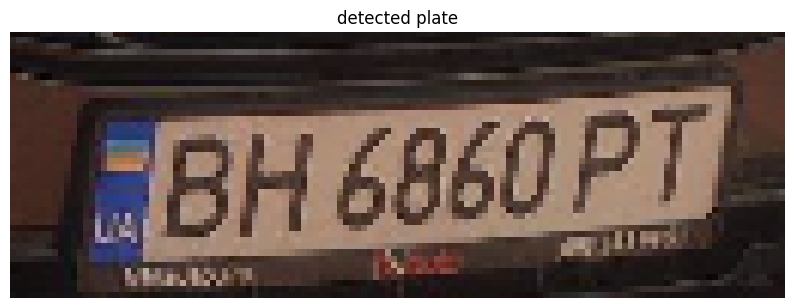

In [1151]:
output_img, plate = extract_plate(img_car_original)

show_image(plate, "detected plate")

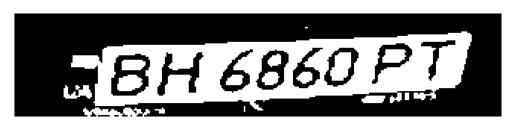

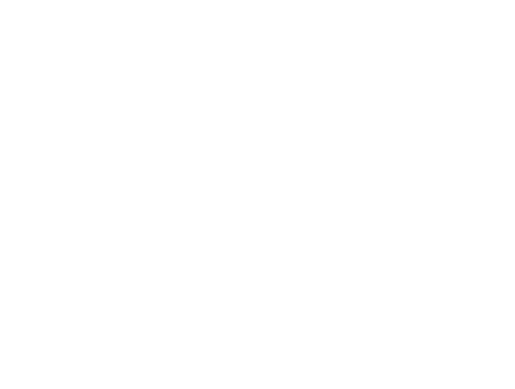

In [1152]:
res =segment_characters(plate, debug = True)

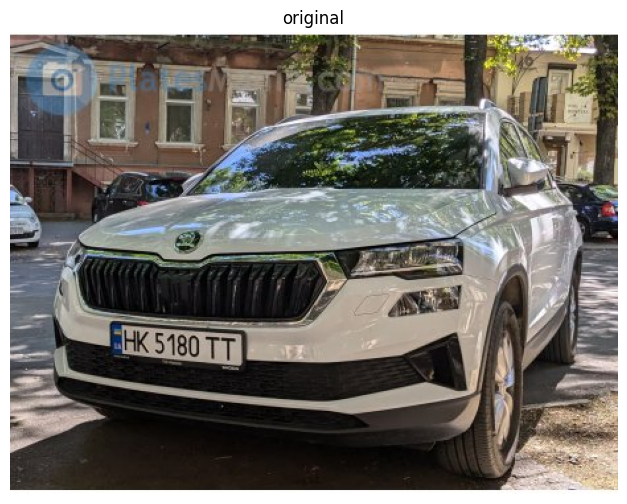

In [1153]:
img_car_original = cv2.imread('image_vehile/HK 5180 TT.jpg')

show_image(img_car_original, "original")

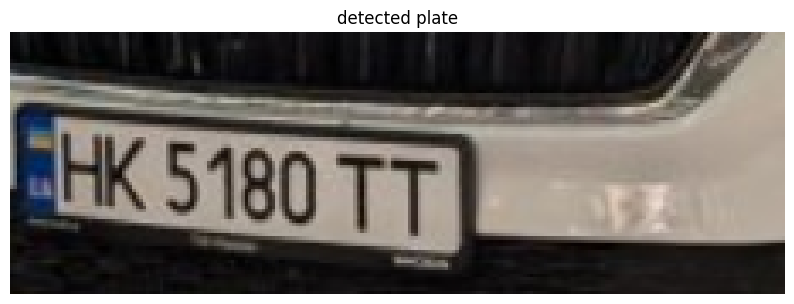

In [1154]:
output_img, plate = extract_plate(img_car_original)

show_image(plate, "detected plate")

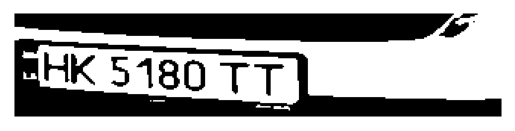

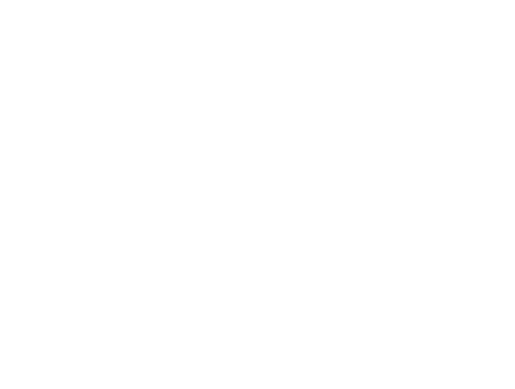

In [1155]:
res = segment_characters(plate, debug = True)

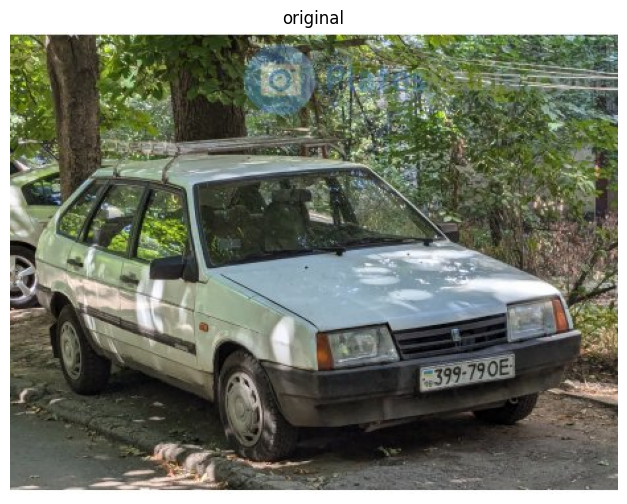

In [1156]:
img_car_original = cv2.imread('image_vehile/16 399-79 OE.jpg')

show_image(img_car_original, "original")

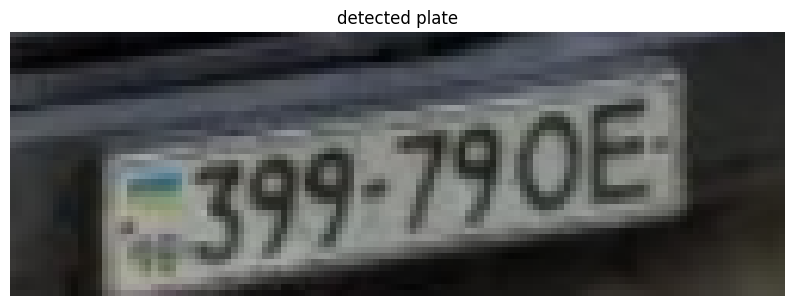

In [1157]:
output_img, plate = extract_plate(img_car_original)

show_image(plate, "detected plate")

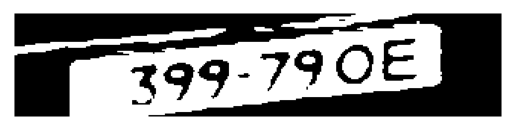

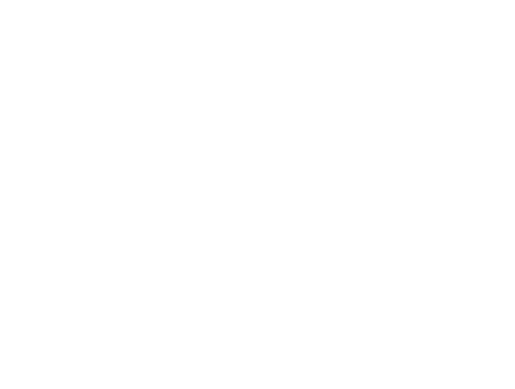

In [1158]:
res = segment_characters(plate, debug = True)